In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [133]:
stock_relation = pd.read_csv("../data_combine/news_alpha/relation_all.csv")
stock_relation = stock_relation[stock_relation['ticker'] == 'NVDA']
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

,Unnamed: 0,news_id,source_ticker,time,ticker,relevance_score,ticker_sentiment_score,ticker_sentiment_label
10,13393,NaN,MSFT,2022-12-31 22:00:28,NVDA,0.006802,-0.081333,Neutral
15,19177,NaN,NVDA,2022-12-31 22:00:28,NVDA,0.006802,-0.081333,Neutral
23,4,NaN,META,2022-12-31 22:00:28,NVDA,0.006802,-0.081333,Neutral
130,19181,NaN,NVDA,2023-01-01 09:00:00,NVDA,0.779232,0.468234,Bullish
159,19186,NaN,NVDA,2023-01-01 13:11:00,NVDA,0.360752,0.189885,Somewhat-Bullish
...,...,...,...,...,...,...,...,...
25352,17563,NaN,MSFT,2024-10-02 16:59:10,NVDA,0.659096,0.237695,Somewhat-Bullish
25359,23645,NaN,NVDA,2024-10-02 16:59:10,NVDA,0.659096,0.237695,Somewhat-Bullish
25362,23649,NaN,NVDA,2024-10-02 17:36:43,NVDA,0.745397,0.442404,Bullish
25370,23650,NaN,NVDA,2024-10-02 17:45:21,NVDA,0.601928,0.397064,Bullish


In [134]:
stock_price = pd.read_csv("../dataset/stocks/NVDA.csv")
stock_price['time'] = pd.to_datetime(stock_price['time'])
stock_price['trade_date'] = stock_price['time'].dt.date
stock_price['delta'] = stock_price['close'].diff()
stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
stock_price

,volumn,vwap,open,close,high,low,time,num_trades,trade_date,delta,prv_close
0,486340990.0,13.5183,13.778,13.497,13.8380,13.2970,2022-10-31 04:00:00,402621,2022-10-31,NaN,NaN
1,432816900.0,13.6873,13.811,13.543,13.9250,13.5190,2022-11-01 04:00:00,374869,2022-11-01,0.046,13.497
2,672627840.0,13.7772,13.850,13.219,14.2100,13.2112,2022-11-02 04:00:00,574395,2022-11-02,-0.324,13.543
3,500064860.0,13.4271,13.043,13.421,13.7810,12.9560,2022-11-03 04:00:00,409161,2022-11-03,0.202,13.219
4,612575910.0,13.9845,13.986,14.156,14.2290,13.6970,2022-11-04 04:00:00,509022,2022-11-04,0.735,13.421
...,...,...,...,...,...,...,...,...,...,...,...
497,281616805.0,139.7055,142.030,139.560,142.4300,137.4600,2024-10-23 04:00:00,1916889,2024-10-23,-4.030,143.590
498,170331532.0,139.9981,140.820,140.410,141.3500,138.4600,2024-10-24 04:00:00,1226444,2024-10-24,0.850,139.560
499,199161159.0,142.5583,140.930,141.540,144.1300,140.8000,2024-10-25 04:00:00,1410829,2024-10-25,1.130,140.410
500,167520099.0,141.1758,143.000,140.520,143.1400,140.0500,2024-10-28 04:00:00,1258016,2024-10-28,-1.020,141.540


<Axes: xlabel='time'>

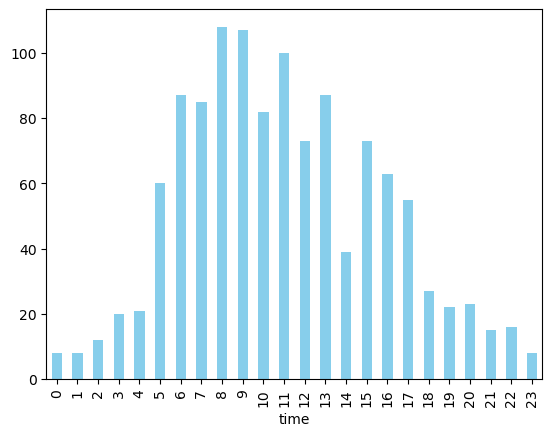

In [135]:
stock_date = stock_relation['time'].dt.hour.value_counts().sort_index()
stock_date.plot(kind='bar', color='skyblue')

In [136]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [137]:
def sentiment_score(threshold, gt):
    def func(series):
        if gt:
            return series[series >= threshold].mean()
        else:
            return series[series <= threshold].mean()
    return func

In [138]:
# relation_t = stock_relation[stock_relation['ticker'] == stock_relation['source_ticker']]
relation_t = stock_relation
relation_t['trade_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
relation_t['weighted_sentiment'] = relation_t['ticker_sentiment_score'] * relation_t['relevance_score']

relation_t['direct_sentiment_score'] = relation_t['ticker_sentiment_score'] * relation_t['same_source']
relation_t['direct_weighted_sentiment'] = relation_t['weighted_sentiment'] * relation_t['same_source']
relation_t['direct_sentiment_label'] = relation_t['ticker_sentiment_label']
relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment_label'] = 'None'

relation_t = relation_t.groupby('trade_date').agg({
    'ticker_sentiment_label': [sentiment_transform(['Bullish']), sentiment_transform(['Bearish']),
    sentiment_transform(['Somewhat-Bullish', 'Bullish']), sentiment_transform(['Somewhat-Bearish', 'Bearish'])],
    'direct_sentiment_label': [sentiment_transform(['Bullish']), sentiment_transform(['Bearish']),
    sentiment_transform(['Somewhat-Bullish', 'Bullish']), sentiment_transform(['Somewhat-Bearish', 'Bearish'])],
    'ticker_sentiment_score': [sentiment_score(0.0, True), sentiment_score(-0.0, False)],
    'weighted_sentiment': [sentiment_score(0.0, True), sentiment_score(-0.0, False)],
    'direct_sentiment_score': [sentiment_score(0.0, True), sentiment_score(-0.0, False)],
    'direct_weighted_sentiment': [sentiment_score(0.0, True), sentiment_score(-0.0, False)],
}).fillna(0.0).reset_index()
relation_t.columns = ['trade_date', 'positive', 'negative', 'sw_pos', 'sw_neg', 'dir_positive', 'dir_negative', 'dir_sw_pos', 'dir_sw_neg',
                      'pos_score', 'neg_score', 'wpos_score', 'wneg_score', 'dir_pos_score', 'dir_neg_score', 'dir_wpos_score', 'dir_wneg_score']

stock_comb = pd.merge(relation_t, stock_price[['trade_date', 'prv_close', 'delta']], how='inner', on='trade_date')
stock_comb_t = stock_comb[stock_comb['sw_neg'] > 0]
stock_comb[['trade_date', 'positive', 'negative', 'sw_pos', 'sw_neg', 'dir_positive', 'dir_negative', 'dir_sw_pos', 'dir_sw_neg']].head(10)

,trade_date,positive,negative,sw_pos,sw_neg,dir_positive,dir_negative,dir_sw_pos,dir_sw_neg
0,2023-01-03,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
1,2023-01-04,0.100000,0.033333,0.466667,0.033333,0.100000,0.033333,0.466667,0.033333
2,2023-01-05,0.000000,0.000000,0.357143,0.000000,0.000000,0.000000,0.285714,0.000000
3,2023-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2023-02-01,0.153846,0.000000,0.384615,0.000000,0.115385,0.000000,0.346154,0.000000
5,2023-02-02,0.214286,0.000000,0.535714,0.071429,0.142857,0.000000,0.285714,0.071429
6,2023-02-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2023-02-07,0.125000,0.000000,0.250000,0.000000,0.125000,0.000000,0.250000,0.000000
8,2023-02-08,0.120000,0.000000,0.360000,0.040000,0.120000,0.000000,0.280000,0.040000
9,2023-02-09,0.045455,0.000000,0.272727,0.000000,0.045455,0.000000,0.227273,0.000000


In [139]:
len(stock_comb_t), len(stock_comb), len(stock_comb_t) / len(stock_comb)

(18, 42, 0.42857142857142855)

In [140]:
X, y = stock_comb_t[['dir_neg_score', 'neg_score', 'prv_close']], stock_comb_t['delta']
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mse, r2, model.coef_

(0.3522056650671348,
 0.34286623183147613,
 array([ 1.72721218, -1.02493445,  0.01889154]))

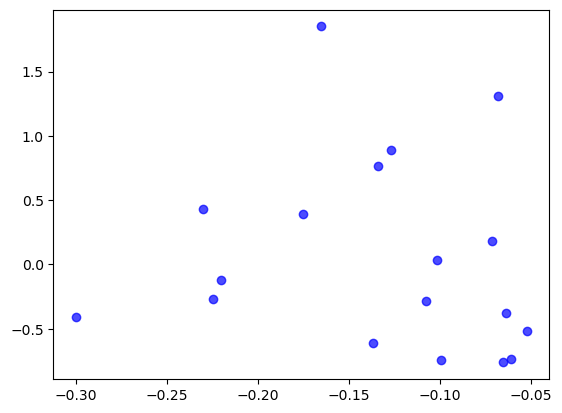

In [141]:
import matplotlib.pyplot as plt

plt.scatter(stock_comb_t['neg_score'], stock_comb_t['delta'], color='blue', alpha=0.7)